# Manually segment images of the discharge board, detect digits and classify them using a convolutional nueral-network. 

## Contents:
## [Section 1: Detect and segment the discharge table](#1.-Detect-and-segment-the-discharge-table)
## [Section 2: Process and extract digits](#2.-Process-and-extract-digits)
## [Section 3: Classification of digits using CNN](#3.-Classification-of-digits-using-CNN)

***
#### Note the following: 
- The demonstration images used here have been blurred out (except for the part the we are interested in). This is for reasons of data security. The method presented here was developed and tested on the original images, which cannot be shared publicly. 

- Camera movement (Rpi was knocked?) means recalibration required at one point during experimental run (at : icu_batch_2/img2018-09-02-23-01.jpg)

***
## 1. Detect and segment the discharge table

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy import ndimage

%matplotlib inline

#### Configure the script:

In [2]:
PLOT_SIZE = 6
TEST_IMAGE = '../test1_blurred.jpg'
TEST_IMAGE_2 = '../test7_blurred.jpg'

#### Load and display a demonstration image of the whiteboard:

In [3]:
def load_image(fname):
    img = cv2.imread(fname)
    img = ndimage.rotate(img, 90)
    img = img[:,:,::-1]
    ## note that openCV uses different colour mapping (BGR)
    ## reversing the ordering of the slices converts to normal RGB
    return img

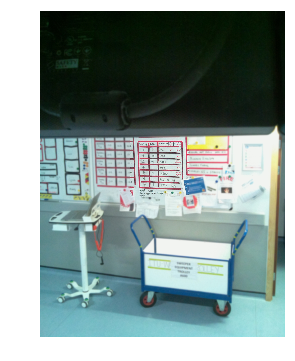

In [4]:
img = load_image(TEST_IMAGE)
plt.figure(figsize=(PLOT_SIZE,PLOT_SIZE)), plt.imshow(img), plt.axis('off');

#### From this image (and many others like it), we want to select the portion of the image that corresponds to the discharge planning table. (Here this is the non-blurred region.) We will then manually segment the table and use a digit recognition classifier to try to automatically recognise the table entries.

#### To find the table, we will use 'template matching' (taken from this tutorial https://docs.opencv.org/3.4/d4/dc6/tutorial_py_template_matching.html).

#### First lets look at the table itself:

In [5]:
table_only = img[1030:1420,765:1140,:]  
detection_template = table_only.copy()  ## We will use this later for the template matching.

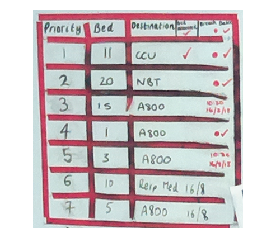

In [6]:
plt.imshow(table_only), plt.axis('off');
np.save('TABLE_TEMPLATE', table_only)

#### We are only really interested in the first two columns:

- The first column should always contain the digits 1-7. Therefore we can consider this as labelled data and use it to test if our digit reconigtion system is working.

- The second column contains the experimental data we are interested in - the bed number of those patients on ICU that are ready for discharge from the unit. Once these digits are recognised we will match the bed numbers to those recorded in the clinical information system. 

#### We now define a couple of classes that do the segmentation of the table image (i.e. they define which parts of the images correspond to the table entries).

In [7]:
class Segment:
    def __init__(self, corner, width, height, colour='lime',linewidth=3):
        self.corner = corner
        self.width = width
        self.height = height
        self.colour = colour
        self.linewidth = linewidth
        
        self.rect = patches.Rectangle(self.corner,self.width,self.height,linewidth=self.linewidth,
                                      edgecolor=self.colour,facecolor='none')
        
    def plot_on_image(self, img):
        fig = plt.figure(figsize=(PLOT_SIZE,PLOT_SIZE))
        ax = plt.gca()
        ax.imshow(img)
        ax.add_patch(self.rect)
        
        return ax
    
    def add_to_axis(self, ax):
        ax.add_patch(self.rect)
        
    def extract_segment_from_image(self, img):
        ## note: numpy indexing is [rows, columns], whereas plt.imshow() effectively displays as transpose
        return img[self.corner[1]:self.corner[1]+self.height, self.corner[0]:self.corner[0]+self.width]

In [8]:
class AllTableSegments:
    def __init__(self, img, camera_angle=1, x_offset=0, y_offset=0, width=60, height=30, plot_flag=True):
        
        self.image = img
        self.x_offset = x_offset
        self.y_offset = y_offset
        self.width = width
        self.height = height
        self.plot_flag = plot_flag
        
        if camera_angle==1:
            ## these segment locations are hand taylored to the image produced by camera position 1
            self.priority_segment_corners = [[25,61], [25,107], [25,153], [27,200], 
                                             [30,244], [31,292], [32, 337]]
        if camera_angle==2:
            ## these segment locations are hand taylored to the image produced by camera position 2
            self.priority_segment_corners = [[33,66], [33,115], [34,160], [35,208], 
                                             [36,253], [38,301], [39, 347]]
            
        self.bed_segment_corners = [[c[0]+80, c[1]+(ci-1)] for ci,c in enumerate(self.priority_segment_corners)]

        ## allows for fine tuning:
        self._apply_offset()
        
        self.extracted_data = []
        self._run_segmentation()
        
    def _apply_offset(self):
        self.priority_segment_corners = [[c[0]+self.x_offset,c[1]+self.y_offset] for c in self.priority_segment_corners]
        self.bed_segment_corners = [[c[0]+self.x_offset,c[1]+self.y_offset] for c in self.bed_segment_corners]
        
    def _run_segmentation(self):
        
        for ci,corner in enumerate(self.priority_segment_corners):
            _seg = Segment(corner,self.width,self.height)
            self.extracted_data.append(_seg.extract_segment_from_image(self.image))
            
            if self.plot_flag:
                if ci==0:
                    ax = _seg.plot_on_image(self.image)
                    plt.axis('off')
                else:
                    _seg.add_to_axis(ax)
                
        for corner in self.bed_segment_corners:
            _seg = Segment(corner,self.width,self.height, colour='cyan')
            if self.plot_flag:
                _seg.add_to_axis(ax)
            
            self.extracted_data.append(_seg.extract_segment_from_image(self.image))

#### The segmentation looks like this:

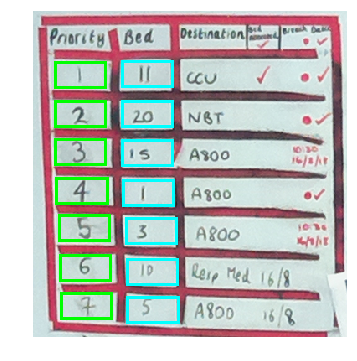

In [9]:
segments = AllTableSegments(table_only, plot_flag=True)

#### Note:
- We tried a number of differnt approaches to detect the table entries (countours, HSV filtering, thresholding), but none were as reliable as the manual segmentation (probably could be with more development!).

- The constructor of AllTableSegments() takes a camera_angle parameter. This is because when the camera angle moves, the image becomes slgithly skewed. The extent of this skew does not stop the template matching, but does mean that the table entries end up in slightly different places. (We also inlude x_offset and y_offset parameters with the intention that these could be used for adaptive segmentation in the future.)

#### Let's examine the segment contents:

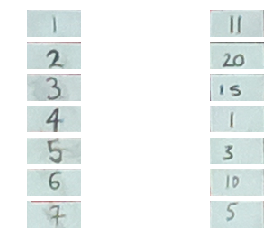

In [9]:
for row in range(7):
    plt.subplot(7,2,1+(2*row))
    plt.imshow(segments.extracted_data[row])
    plt.axis('off')
    plt.subplot(7,2,2+(2*row))
    plt.axis('off')
    plt.imshow(segments.extracted_data[row+7])

#### The manual segmentation is pretty good, but not perfect. One thing we will need to do is trim any remaining border from the image.

#### First we use template matching to locate the discharge table from within another image (with the slightly different camera angle):

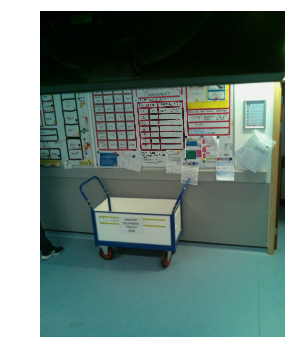

In [10]:
img2 = load_image(TEST_IMAGE_2)
plt.figure(figsize=(PLOT_SIZE,PLOT_SIZE)), plt.imshow(img2), plt.axis('off');

In [11]:
template = detection_template
h, w, _ = template.shape

#### Here we find the location of the template within the new image:

In [12]:
img_c = img2.copy()
res = cv2.matchTemplate(img_c,template,cv2.TM_CCOEFF)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
## note: whether you take the max or min depends on the matcihng method (here 'TM_CCOEFF')
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)
cv2.rectangle(img_c,top_left, bottom_right, 255, 5);

#### And visualise the result:

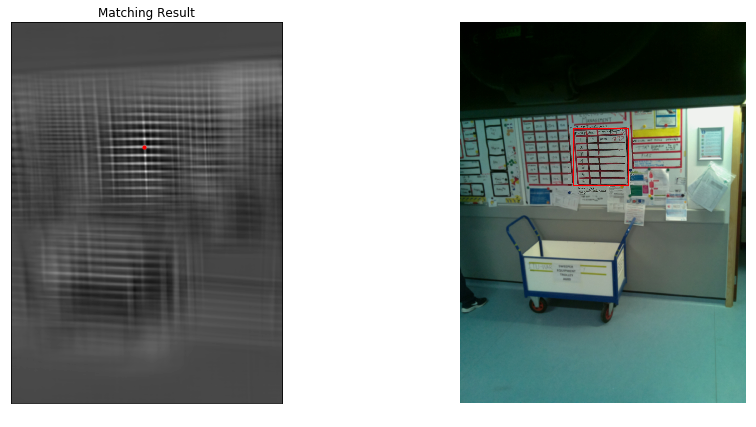

In [13]:
plt.figure(figsize=(15,7))
plt.subplot(121),plt.imshow(res,cmap = 'gray');
plt.scatter([max_loc[0]], [max_loc[1]], c='r',s=10);
plt.title('Matching Result'), plt.xticks([]), plt.yticks([]);
plt.subplot(122),plt.imshow(img_c,cmap = 'gray'),plt.axis('off');

#### The template is correctly identified within the new image (despite the table containing different values than in the template, and the difference in camera angle). This works for the non-blurred images also!

#### We now apply the same manual image segmentation to the detected table, to locate the table entries.

#### First we rotate the detected table slightly, to adjust for the skew from the new camera anlge:

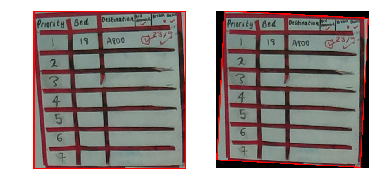

In [14]:
detected_table = img_c[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w].copy()
plt.subplot(1,2,1)
plt.imshow(detected_table), plt.axis('off');
plt.subplot(1,2,2)
detected_table = ndimage.rotate(detected_table, -3)
plt.imshow(detected_table), plt.axis('off');

#### We then instantiate the same AllTableSegments class, specifiying that this image was taken from camera_angle 2:

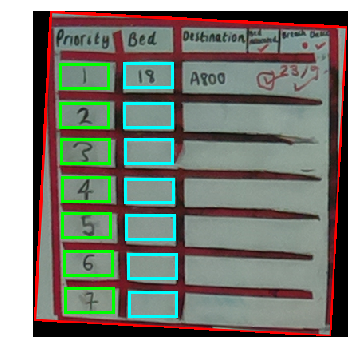

In [15]:
segments = AllTableSegments(detected_table, camera_angle=2)

#### Producing  the following table entries:

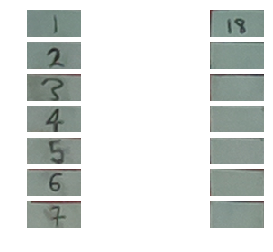

In [16]:
for row in range(7):
    plt.subplot(7,2,1+(2*row))
    plt.imshow(segments.extracted_data[row])
    plt.axis('off')
    plt.subplot(7,2,2+(2*row))
    plt.axis('off')
    plt.imshow(segments.extracted_data[row+7])

***
## 2. Process and extract digits

#### Lets look at the double digit 18 found at the top of the second table column:

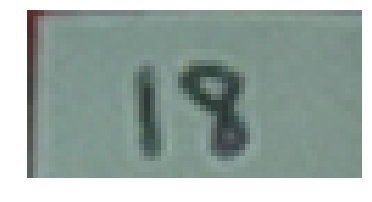

In [17]:
entry = segments.extracted_data[7]
plt.imshow(entry),plt.axis('off');

#### We covnvert this image to grayscale:

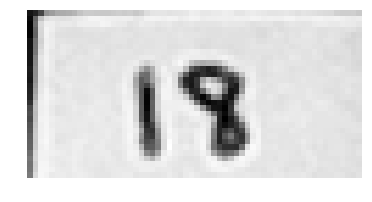

In [18]:
entry = cv2.cvtColor(entry, cv2.COLOR_RGB2GRAY)
entry = entry.astype(int)
entry = np.max(entry) - entry
plt.imshow(entry, cmap='Greys'),plt.axis('off');

#### We then define a method to calculate (normalised) total pixel intensity, projected onto the x and the y-axes: 

In [19]:
def xy_intensities(image):
    x_intensities = np.sum(image,0)
    y_intensities = np.sum(image,1)
    
    x_intensities = x_intensities - np.min(x_intensities)
    y_intensities = y_intensities - np.min(y_intensities)
    
    x_intensities = x_intensities/float(np.max(x_intensities))
    y_intensities = y_intensities/float(np.max(y_intensities))
    
    return x_intensities, y_intensities

In [20]:
x_intensities, y_intensities = xy_intensities(entry)

#### For the '18' shown above, these intensity profiles look like this:

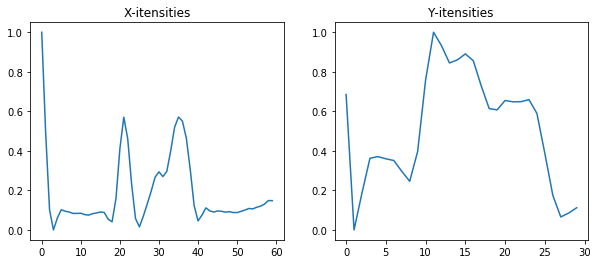

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('X-itensities')
plt.plot(range(np.shape(entry)[1]), x_intensities);
plt.subplot(1,2,2)
plt.title('Y-itensities')
plt.plot(range(np.shape(entry)[0]), y_intensities);

- From the x-axis projection we see the double-peak profile indicating the locations of the two digits ('1' and '8').

- From the y-axis projection we roughly see the digits located vertically in the image.

- From both projections we see a signature of the remaining border that needs trimming from the image.

#### To trim the remaining border we descend from the image edge, up to the first intensity minimum (provided this is not too far in to the image). We do this for all for edges. We replace all lost pixels with random noise that approximately matches the background:

In [22]:
def descend(values, max_vi=5):
    
    for vi,val in enumerate(values[1:]):
        dx = val - values[vi]
        if dx>0:
            break
            
    ## if the routine is just eating the image, rather than trimming, reject
    vi = 0 if vi>=max_vi else vi
    return vi

def trim_edges(image, x_intensities, y_intensities, bkg=60, verbose=False):
    
    background = image[image<=np.percentile(image, bkg)]
    mu = np.mean(background)
    sigma = np.sqrt(np.std(background))
    
    trimed = image.copy()
    lb = descend(x_intensities)
    ub = len(x_intensities) - descend(x_intensities[::-1])
    trimed[0:lb, :] = np.random.normal(mu, sigma, size=(lb,np.shape(trimed)[1]))
    trimed[ub:, :] = np.random.normal(mu, sigma, size=(np.shape(trimed)[0]-ub,np.shape(trimed)[1]))
    if verbose:
        print "Y-minima located at: %d, %d "%(lb,ub)
    
    lb = descend(y_intensities)
    ub = len(y_intensities) - descend(y_intensities[::-1])
    if verbose:
        print "X-minima located at: %d, %d "%(lb,ub)
        
    trimed[:, 0:lb] = np.random.normal(mu, sigma, size=(np.shape(trimed)[0],lb))
    trimed[:, ub:] = np.random.normal(mu, sigma, size=(np.shape(trimed)[0],np.shape(trimed)[1]-ub))
    
    return trimed

In [23]:
trimed_image = trim_edges(entry, y_intensities, x_intensities, verbose=True) 

Y-minima located at: 1, 28 
X-minima located at: 3, 60 


#### The trimmed image look like this:

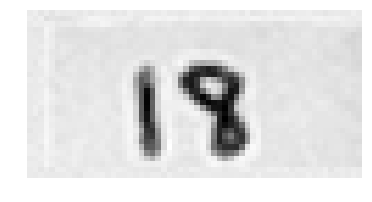

In [24]:
plt.imshow(trimed_image, cmap='Greys'),plt.axis('off');

#### Next we test for the presence of double digits.

#### We recalculate the x- and y-axis intensity projections, and use the x-axis projection to test for the double peak signature seen above.

In [25]:
x_intensities, y_intensities = xy_intensities(trimed_image)

In [26]:
def criteria_on_minimum_and_maxima(global_max, central_min, second_max, min_thresh=0.6, peak_thresh=0.6):
    result = central_min/float(global_max)<=min_thresh
    result *= second_max/float(global_max)>=peak_thresh
    return result
    
def test_for_double_digits(y_intensities, mav_len=5, minimum_threshold=0.6, second_peak_threshold=0.6, plot_flag=False):
    ## Smooth the intensities
    ## Find lowest point between two highest peaks
    ## If low point is 'low enough' and second peak is 'high enough' -> two digits
    ## This is unlikley to be robust! (Look at bimodality testing, or adaptive thresholding?)
    
    y_smooth = np.convolve(y_intensities, np.ones((mav_len,))/mav_len, mode='valid')
    y_p = np.diff(y_smooth)
    ## find all the maxima (diff changes +->- when moving LR)
    maxima = dict()
    for yi,grad in enumerate(y_p[1:]):
        if grad<0 and y_p[yi]>0:
            maxima[yi+1] = y_smooth[yi+1]
    
    if len(maxima.values())==0:
        ## method fails - return as if single digit, but most likely there is no digit present
        return False, (None, 0, None)

    global_maximum = np.max(maxima.values())
    double_peak_locations = [k for k in maxima.keys() if maxima[k]==global_maximum]
    global_maximum_location = double_peak_locations[0]
    maxima[global_maximum_location] = 0
    second_maximum = np.max(maxima.values())
    double_peak_locations.append([k for k in maxima.keys() if maxima[k]==second_maximum][0])
    ## put peaks in true order (left to right)
    double_peak_locations = double_peak_locations[::-1] if double_peak_locations[0]>double_peak_locations[1] else double_peak_locations

    if len(double_peak_locations)!=2 or double_peak_locations[0]==double_peak_locations[1] or double_peak_locations[1]>=len(y_smooth):
        ## method fails - return as if single digit, but most likely there is no digit present
        return False, (None, global_maximum_location, None)
    
    ## find lowest point between these two peaks
    central_minimum = np.min(y_smooth[double_peak_locations[0]:double_peak_locations[1]])
    central_minimum_location = np.argmin(y_smooth[double_peak_locations[0]:double_peak_locations[1]]) 
    central_minimum_location += double_peak_locations[0]
    
    if plot_flag:
        plt.plot(y_smooth)
        ax = plt.gca()
        ax.axvline(central_minimum_location, color='r')
        for m in double_peak_locations:
            ax.axvline(m)

    if criteria_on_minimum_and_maxima(global_maximum, central_minimum, second_maximum, minimum_threshold, second_peak_threshold):
        ## conlcude double digits
        return True, (double_peak_locations[0], central_minimum_location, double_peak_locations[1])
    else:
        return False, (None, global_maximum_location, None)

#### The double peak detection looks like this:

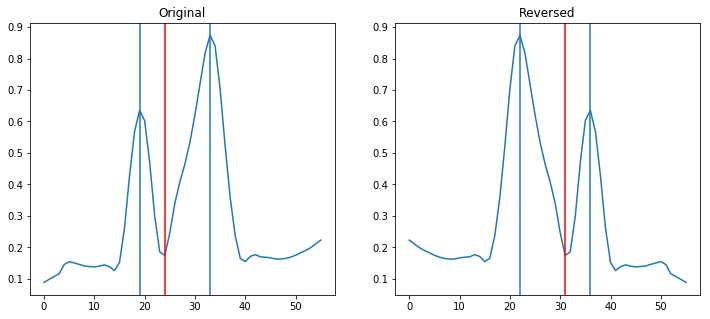

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Original')
test_for_double_digits(x_intensities, plot_flag=True);
plt.subplot(1,2,2)
plt.title('Reversed')
test_for_double_digits(np.flip(x_intensities), plot_flag=True);

#### Above we see the double digit detection working for the original image and the reversed image ('81'). This procedure has been manually tested and calibrated for a handful of examples (because we lack labelled training data), more extensive testing is required to determine its effectiveness.

- Here the red line indicates the separating minimum (i.e. the detected gap between the digits), and the blue lines indicate the two detected maxima. Note that this intensity profile has been smoothed with a moving-average filter.

***
### We now chain the above prodcedure into a pipeline for digit extraction.

#### If a double digit is detected, we split the image at the minimum. We then mask with random noise as required. And then threshold (with a high value) to ensure we only have foreground, finding the centre of mass of the foreground (ideally this is the centre of mass of the digit we want to detect). We then centre a square frame of 28x28 pixels on this centre of mass, and define this as the detected digit. 

#### Note: the above produces images that are consistent with the MNIST data we will use for training a classifier, which consists of 28x28 pixel grayscale images of hand-written digits.

In [28]:
def crop_digit(digit, plot_flag=True, bkg=60):

    mask = digit>np.percentile(digit, 95)
    foreground = digit*mask
    com = ndimage.measurements.center_of_mass(foreground)
    
    ## check if top of left hand edges of cropping square overhang 'digit' image (and adjust if necessary)
    lb0 = int(com[0])-14 if com[0]>=14 else 0
    lb1 = int(com[1])-14 if com[1]>=14 else 0
    ## not an issue if up index is too large (i.e. overhangs right or bottom)
    ub0 = int(com[0])+14
    ub1 = int(com[1])+14

    digit_only = digit[lb0:ub0, lb1:ub1]
    
    if np.shape(digit_only)!=(28,28):
        ## there was an overhang. We fill the gap with Gaussian background noise.
        mu = np.mean(digit[digit<=np.percentile(digit,bkg)])
        sigma = np.sqrt(np.std(digit[digit<=np.percentile(digit,bkg)]))
        background = np.random.normal(mu,sigma,size=(28,28))
        background[0:np.shape(digit_only)[0],0:np.shape(digit_only)[1]] = digit_only
        digit_only = background
    
    if plot_flag:
        plt.figure()
        plt.subplot(2,2,1)
        plt.imshow(foreground),plt.axis('off')
        plt.plot(com[1], com[0], 'or')
        plt.subplot(2,2,2)
        plt.imshow(digit_only),plt.axis('off')
    
    return digit_only

def extract_digits(table_entry, bkg=40, grayscale=False):
    
    ## from table entry box, returns digit image(s)
    image = table_entry.copy()
    if not grayscale:
        ## convert to grayscale:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ## convert to singed ineger and invert:
        image = image.astype(int)
        image = np.max(image) - image
    ## get intensities summed along x and y axes:
    x_intensities, y_intensities = xy_intensities(image)
    ## trim edges (to remove any remaining border):
    trimed_image = trim_edges(image, y_intensities, x_intensities, bkg=bkg) 
    ## recalculate intensities:
    x_intensities, y_intensities = xy_intensities(trimed_image)
    ## test for double digits:
    double_digit, split_loc = test_for_double_digits(x_intensities)
    
    if double_digit:
        print "Double digit number detected:"
        ## in the case of double digits we return the digits individually, 
        ## masking over the other digit with random noise
        background_intensity = trimed_image[trimed_image<=np.percentile(trimed_image, bkg)]
        mu = np.mean(background_intensity)
        sigma = np.sqrt(np.std(background_intensity))

        first_digit = trimed_image.copy()
        first_digit[:,split_loc[1]::] = np.random.normal(mu,sigma, size=(np.shape(first_digit)[0], np.shape(first_digit)[1]-split_loc[1]))

        second_digit = trimed_image.copy()
        second_digit[:,:split_loc[1]] = np.random.normal(mu,sigma, size=(np.shape(second_digit)[0], split_loc[1]))
        
        digit_1_only = crop_digit(first_digit, bkg=bkg)
        digit_2_only = crop_digit(second_digit, bkg=bkg)
        num_digits = 2
        
    else:
        print "Looks like a single digit:"
        digit = trimed_image.copy()
        digit_1_only = crop_digit(digit, bkg=bkg)
        digit_2_only = None
        num_digits = 1
    
    return num_digits, digit_1_only, digit_2_only

#### Calling this method on our number '18' table entry: 

Double digit number detected:


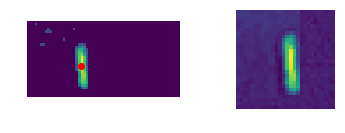

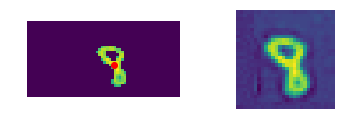

In [29]:
nd, digit1, digit2 = extract_digits(entry, grayscale=True);
np.save('test_digit_1', digit1)
np.save('test_digit_8', digit2)

#### It is likley that some further image processing will be required to work well with the MNIST data. For example, the MNIST images have no noise in the background. To achieve this we could either use thresholding, filtering, or contours to extract the foreground. 

#### We save a few unprocessed digits for testing:

Looks like a single digit:
Looks like a single digit:
Looks like a single digit:


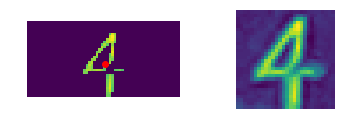

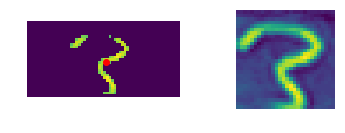

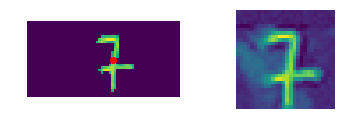

In [31]:
test = segments.extracted_data[3]
nd, digit, _ = extract_digits(test);
np.save('test_digit_4', digit)

test = segments.extracted_data[2]
nd, digit, _ = extract_digits(test);
np.save('test_digit_3', digit)

test = segments.extracted_data[6]
nd, digit, _ = extract_digits(test);
np.save('test_digit_7', digit)

#### The issue with noise in the background is very apparent (esp. with 3 and 7 above). Also, in testing the CNN classifier, it was determined that some further processing was required to get good performance. 

#### We implement a naive approach to contour extraction, to get just the image foreground:

Detected 1 contours in thresholded image. 


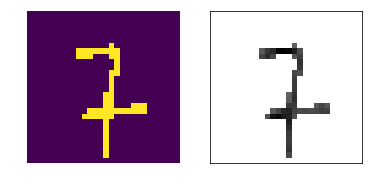

In [35]:
## first we threshold the image:
imgray =  digit.astype('uint8')
ret, thresh = cv2.threshold(imgray, 70, 255, 0)
plt.subplot(1,2,1)
plt.imshow(thresh),plt.axis('off');

## then extract the contours (taking the longest one only):
im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print "Detected %d contours in thresholded image. " %(len(contours))

## take only the subset of the original image that lies within the longest contour:
longest_contour = np.max([len(c) for c in contours])
mask = np.zeros(imgray.shape[:2], dtype="uint8") 
plt.subplot(1,2,2)
for cnt in contours:
    if len(cnt)==longest_contour:
        cv2.drawContours(mask, [cnt], -1, 255, -1)
        new_image = cv2.bitwise_and(imgray, imgray, mask=mask)
        
plt.imshow(new_image, cmap='Greys');
ax = plt.gca()
ax.axes.xaxis.set_ticks([]), ax.axes.yaxis.set_ticks([]);

#### Save for testing:

In [38]:
np.save('test_digit_7_contoured', new_image)

- This contour extraction seems to work OK. 
<br><br>
- However, like everything above: 1. It has only been developed and tested on a small number of cases, so we can't expect it to be robust; 2. It is a 'first-pass' approach i.e. there is scope for improvement at every stage of the prcoessing pipeline. Obviously the better the images processing and digit extraction work, the better the classifier is likely to perform.
<br><br>
- There is no limit really to how much time could be put in to improving these methods. However, given that the use case is pretty limited (we just want to extract the digits from a finite set of ~1000 experimental images), where we have got to is probably sufficient, at least for now.

***
## 3. Classification of digits using CNN

#### We will now test these digits on a machine learning classifier. We can expect imperfect performance. Therefore we will produce a human-validation interface to allow quick human checking (and correction) of the classifier predictions.

In [40]:
from keras.models import load_model
model = load_model('naive_cnn_20_epochs');

- The 'model' is a CNN trained on the 60,000-sample training set of MNIST (see Digit_recognition_cnn.ipynb for details).

- Note: this model had a classification accuracy of 0.9859 on the MINST test set.

#### To use with the model our 'contoured' image must be normalised like the MNIST images:

In [41]:
new_image = new_image.astype('float32')
new_image /= 255

#### We can then query the model to find the probability that this digit belongs to each class (i.e. digits 0-9):

In [42]:
pred = model.predict_proba(new_image.reshape(1, 28, 28, 1))
print "Predicted digit: " + str(pred.argmax())
print ""
for i,pi in enumerate(pred[0]):
    print "    P(y=%d) = %.5f" %(i,pi)

Predicted digit: 7

    P(y=0) = 0.00000
    P(y=1) = 0.00043
    P(y=2) = 0.01084
    P(y=3) = 0.00059
    P(y=4) = 0.00000
    P(y=5) = 0.00000
    P(y=6) = 0.00000
    P(y=7) = 0.98813
    P(y=8) = 0.00000
    P(y=9) = 0.00000


#### In this case the CNN gets it right. (Although, as we shall see, 7 is one of the most problematic digits.)
<br>
***
### We now try the FULL procedure (from table detection, through digit extraction to CNN classification) on the first image we looked at in this script.

#### Much of the code above has been wrapped into helper functions/classes in manualSegmentation.py, as has code developed in other notebooks in digitRecognition.py. We import these modules to use here:

In [43]:
import manualSegmentation as ms
import digitRecognition as dr
import pandas as pd
img = load_image(TEST_IMAGE)

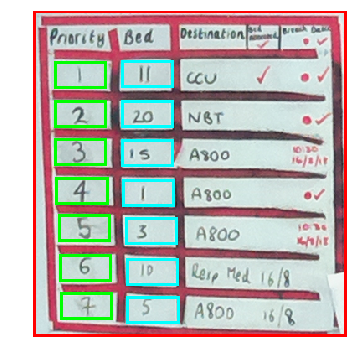

In [44]:
detected_table = ms.detect_table(img, plot_flag=False)
segments = ms.AllTableSegments(detected_table, camera_angle=1, plot_flag=True)

In [45]:
labels_predictions = pd.DataFrame()

true_labels = [i+1 for i in range(7)]
true_labels.extend([11,20,15,1,3,10,5])

labels_predictions['label'] = true_labels
labels_predictions['prediction'] = [dr.process_table_entry(entry, model)[0] for entry in segments.extracted_data]
labels_predictions['correct'] = labels_predictions['prediction']==labels_predictions['label']
labels_predictions

,label,prediction,correct
0,1,7,False
1,2,7,False
2,3,3,True
3,4,4,True
4,5,5,True
5,6,6,True
6,7,7,True
7,11,11,True
8,20,20,True
9,15,13,False


#### It doesn't do badly! But it is obvioulsy not good enough to trust with our data extraction 'in the wild' without any human supervision.

#### Note: we probably could build a fully automated system in the future for process evaluation. But it will take more work.

#### We identify the following issues as the easiest wins for improving the system (some visible in plot dump below, others identified in Naive_sgmentation_classification.ipynb):

- Apparent tendency of classfier to favour 7 (see missclassified 1 and 2 below, despite very clear images). See other notebook: 2 is frequently missclassified as a 7.
- Numbers being misclassified because of partial-thresholding, or contour failure (see misclassified 10 below)
- Tendency of double digit detector to erroneously split single digits (especially 7). See other notebook.
- Could see improvement by only using 'best' of each 3-image hourly burst (as measured by accuracy on known first column).
- Extra processing steps to adjust for variation in image brightness and boldness of hand drawn lines would likely improve performance.
- In the future, further stanadising the usage of the board would make automated evaluation more feasible. 

#### The following (messy) plot dump gives some insight into the processing of the table entries: 

/home/rusty/anaconda3/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


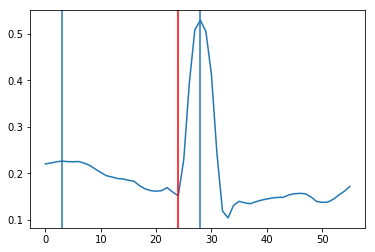

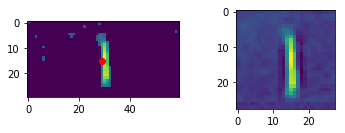

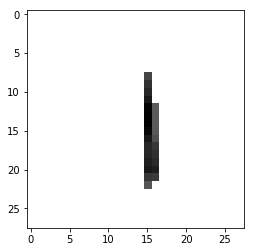

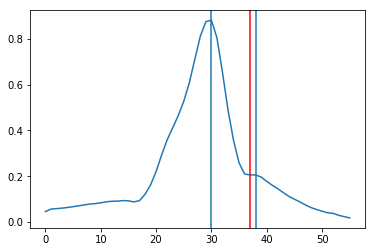

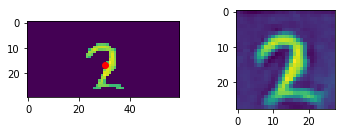

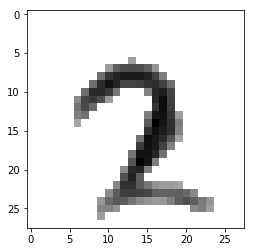

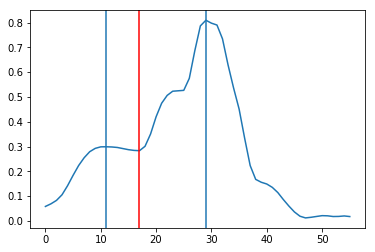

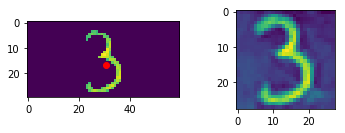

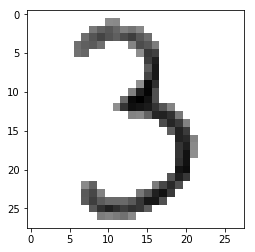

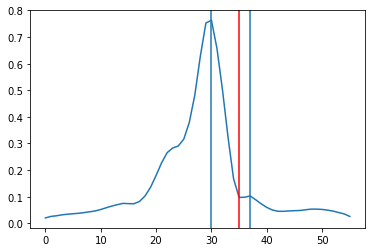

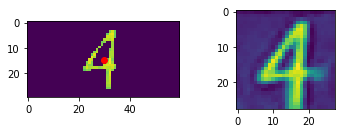

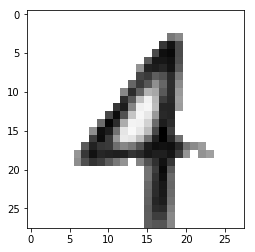

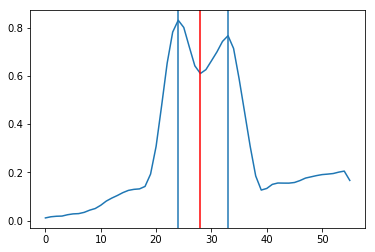

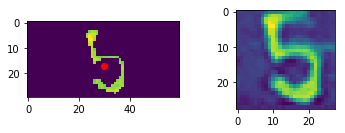

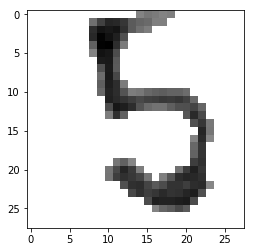

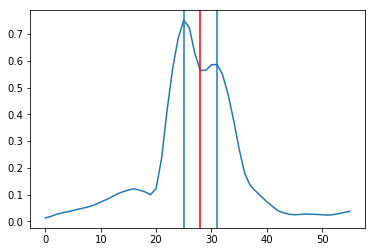

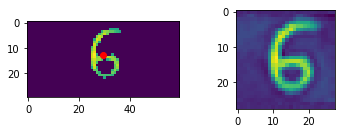

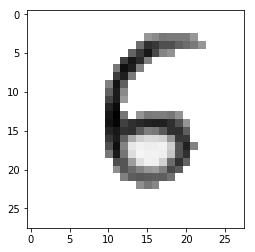

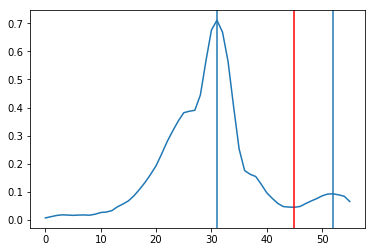

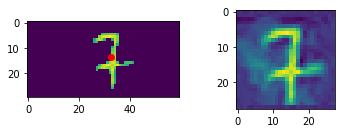

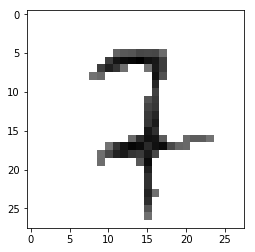

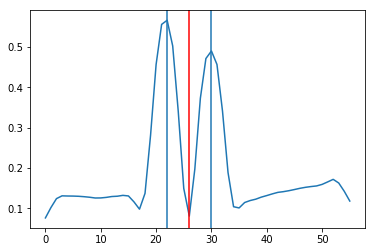

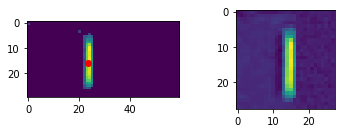

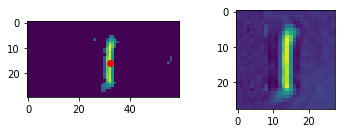

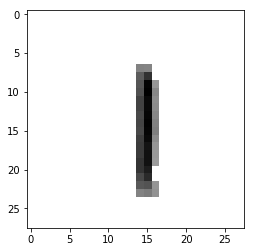

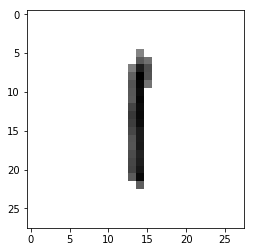

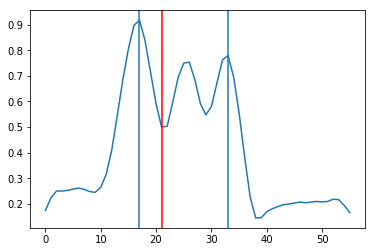

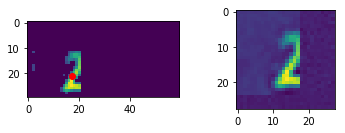

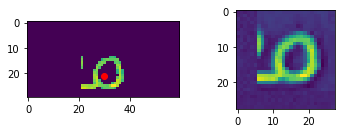

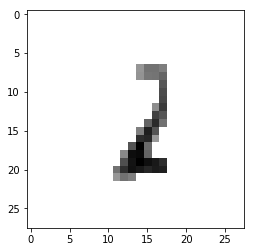

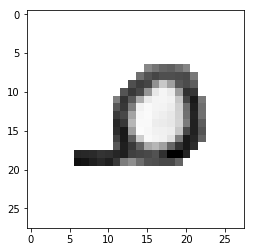

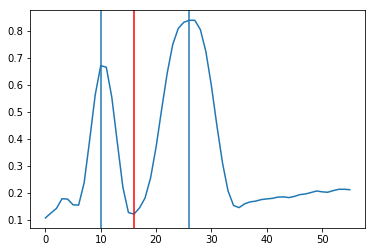

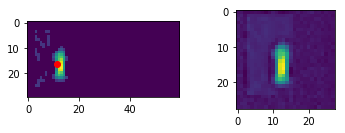

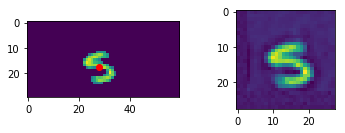

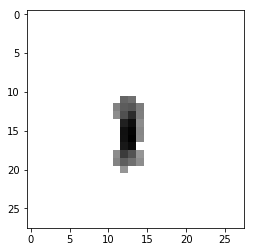

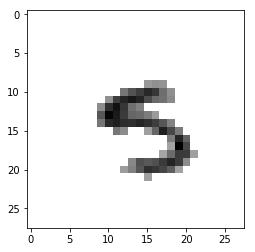

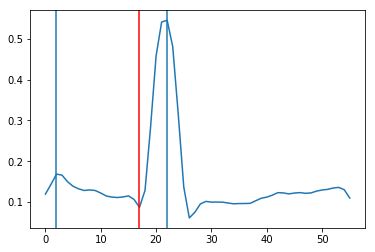

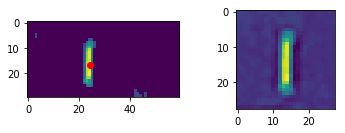

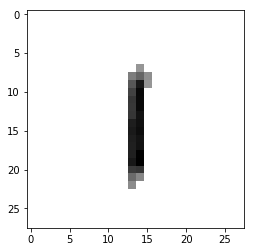

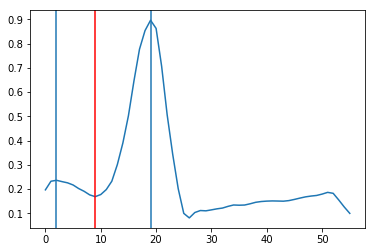

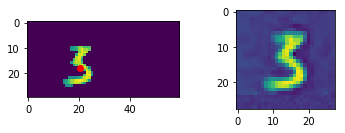

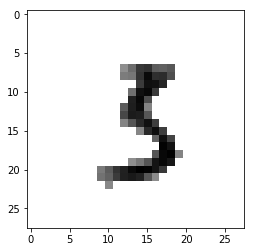

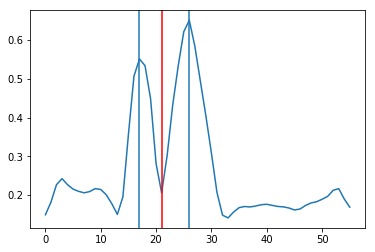

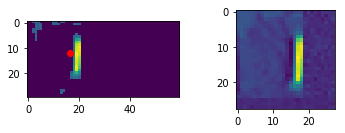

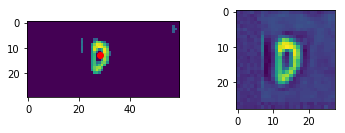

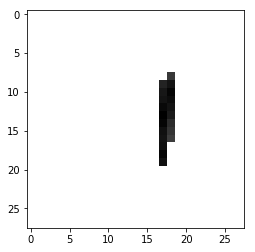

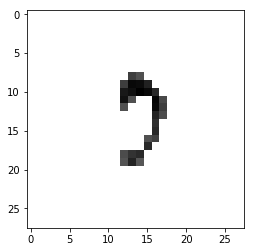

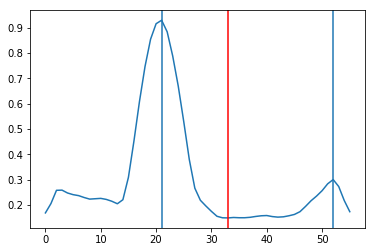

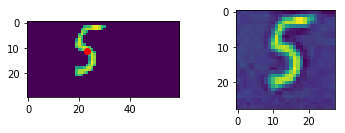

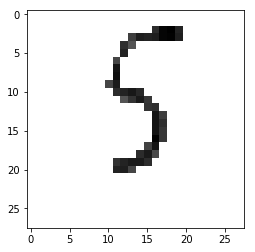

In [46]:
for ei,entry in enumerate(segments.extracted_data):
    dr.process_table_entry(entry, model, plot_flag=True);

#### In order to facilitate human validation of the classifier predictions we produce annotated images as follows:

In [47]:
def show_annotated_table(table, predictions):
    plt.figure(figsize=(8,8))
    plt.imshow(table), plt.axis('off');
    block = patches.Rectangle([180,50],180,330,linewidth=3,
                                          edgecolor='cyan',facecolor='white')
    ax = plt.gca()
    ax.add_patch(block)

    prediction_locations = [[200,80],                         
                            [200,130],                         
                            [200,175],                         
                            [200,220],                        
                            [200,270],                         
                            [200,320],                         
                            [200,365], 
                            [290,80], 
                            [290,130],
                            [290,175],
                            [290,220],
                            [290,270], 
                            [290,320],
                            [290,365]]

    predictions = [p if not np.isnan(p) else -1 for p in predictions]
    for pi,pr in enumerate(predictions):
        ax.annotate("%d" %pr, prediction_locations[pi], fontsize=20, color='blue')

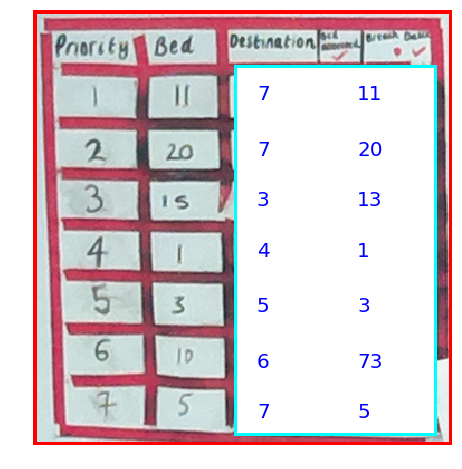

In [48]:
predictions = list(labels_predictions['prediction'])
show_annotated_table(detected_table, predictions)

#### The validation script will then request user input to correct any cases where the prediction does not match the table entry. This input will be stored to produce a validated and fully labelled dataset.

The user input will be requested in the following format (where the first digit is the table location, and the second is the correct label):

'1:1 2:2 9:15 13:10'